In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


c:\Users\HANIN\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
# Load CIFAR-10 dataset with data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
# CNN Model with Dropout
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [5]:
# Training CNN Model
for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_accuracy = 100 * correct / total
    scheduler.step()
    print(f'Epoch {epoch+1}, CNN Loss: {running_loss/len(trainloader)}, CNN Train Accuracy: {train_accuracy:.2f}%')


Epoch 1, CNN Loss: 1.2030795606810722, CNN Train Accuracy: 57.35%
Epoch 2, CNN Loss: 0.8817896666124349, CNN Train Accuracy: 69.17%
Epoch 3, CNN Loss: 0.7713294886719541, CNN Train Accuracy: 73.04%
Epoch 4, CNN Loss: 0.7067990310661628, CNN Train Accuracy: 75.33%
Epoch 5, CNN Loss: 0.6418351098856963, CNN Train Accuracy: 77.78%
Epoch 6, CNN Loss: 0.5516260439325171, CNN Train Accuracy: 80.78%
Epoch 7, CNN Loss: 0.509559185151249, CNN Train Accuracy: 82.25%
Epoch 8, CNN Loss: 0.48051004938762204, CNN Train Accuracy: 83.18%
Epoch 9, CNN Loss: 0.4594678955767161, CNN Train Accuracy: 83.99%
Epoch 10, CNN Loss: 0.44183700731800646, CNN Train Accuracy: 84.72%
Epoch 11, CNN Loss: 0.3816112686529794, CNN Train Accuracy: 86.91%
Epoch 12, CNN Loss: 0.36178171855714314, CNN Train Accuracy: 87.41%
Epoch 13, CNN Loss: 0.35188802718506446, CNN Train Accuracy: 87.87%
Epoch 14, CNN Loss: 0.3370958622687918, CNN Train Accuracy: 88.31%
Epoch 15, CNN Loss: 0.324208005157578, CNN Train Accuracy: 88.72%
Ep

In [6]:
# Evaluate CNN Model
cnn_model.eval()
y_true_cnn = []
y_pred_cnn = []
y_scores_cnn = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true_cnn.extend(labels.cpu().numpy())
        y_pred_cnn.extend(predicted.cpu().numpy())
        y_scores_cnn.extend(torch.softmax(outputs, dim=1).cpu().numpy())

accuracy_cnn = accuracy_score(y_true_cnn, y_pred_cnn)
precision_cnn = precision_score(y_true_cnn, y_pred_cnn, average='macro')
recall_cnn = recall_score(y_true_cnn, y_pred_cnn, average='macro')
f1_cnn = f1_score(y_true_cnn, y_pred_cnn, average='macro')
roc_auc_cnn = roc_auc_score(y_true_cnn, y_scores_cnn, multi_class='ovr')


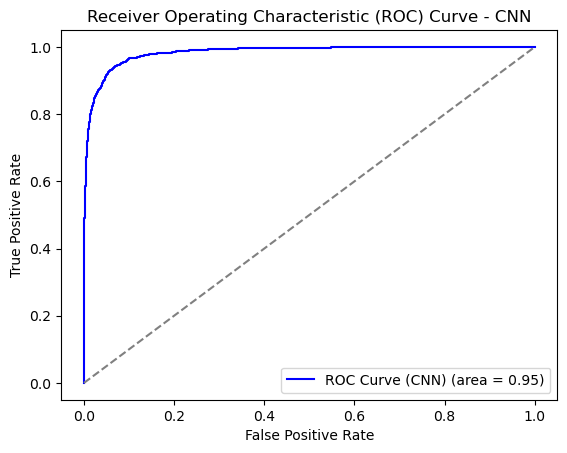

Test Accuracy (CNN): 0.6321
Precision (CNN): 0.7287
Recall (CNN): 0.6321
F1 Score (CNN): 0.6353
ROC AUC (CNN): 0.9519


In [7]:
# Plot ROC Curve for CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_true_cnn, np.array(y_scores_cnn)[:, 1], pos_label=1)
plt.figure()
plt.plot(fpr_cnn, tpr_cnn, color='blue', label=f'ROC Curve (CNN) (area = {roc_auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - CNN')
plt.legend(loc='lower right')
plt.show()

print(f'Test Accuracy (CNN): {accuracy_cnn:.4f}')
print(f'Precision (CNN): {precision_cnn:.4f}')
print(f'Recall (CNN): {recall_cnn:.4f}')
print(f'F1 Score (CNN): {f1_cnn:.4f}')
print(f'ROC AUC (CNN): {roc_auc_cnn:.4f}')


In [8]:
# MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

mlp_model = MLP().to(device)
criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.AdamW(mlp_model.parameters(), lr=0.0005)
scheduler_mlp = optim.lr_scheduler.StepLR(optimizer_mlp, step_size=5, gamma=0.5)


In [9]:
# Training MLP Model
for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 32 * 32 * 3)
        optimizer_mlp.zero_grad()
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_mlp.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}, MLP Loss: {running_loss/len(trainloader)}, MLP Train Accuracy: {train_accuracy:.2f}%')


Epoch 1, MLP Loss: 1.7232154885216442, MLP Train Accuracy: 38.08%
Epoch 2, MLP Loss: 1.5398592570858538, MLP Train Accuracy: 44.95%
Epoch 3, MLP Loss: 1.4698661300532347, MLP Train Accuracy: 47.51%
Epoch 4, MLP Loss: 1.425713819615981, MLP Train Accuracy: 49.14%
Epoch 5, MLP Loss: 1.394123827404988, MLP Train Accuracy: 50.32%
Epoch 6, MLP Loss: 1.3651932407827938, MLP Train Accuracy: 51.07%
Epoch 7, MLP Loss: 1.3369915271963915, MLP Train Accuracy: 52.30%
Epoch 8, MLP Loss: 1.3135363272083995, MLP Train Accuracy: 52.91%
Epoch 9, MLP Loss: 1.2949295117117254, MLP Train Accuracy: 53.80%
Epoch 10, MLP Loss: 1.2755275720830463, MLP Train Accuracy: 54.64%
Epoch 11, MLP Loss: 1.2633032467968934, MLP Train Accuracy: 54.91%
Epoch 12, MLP Loss: 1.2457975408305293, MLP Train Accuracy: 55.59%
Epoch 13, MLP Loss: 1.233281747307009, MLP Train Accuracy: 56.08%
Epoch 14, MLP Loss: 1.2203677295114073, MLP Train Accuracy: 56.64%
Epoch 15, MLP Loss: 1.209821294640641, MLP Train Accuracy: 56.90%
Epoch 16

In [10]:
# Evaluate MLP Model
y_true_mlp = []
y_pred_mlp = []
y_scores_mlp = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 32 * 32 * 3)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true_mlp.extend(labels.cpu().numpy())
        y_pred_mlp.extend(predicted.cpu().numpy())
        y_scores_mlp.extend(torch.softmax(outputs, dim=1).cpu().numpy())

accuracy_mlp = accuracy_score(y_true_mlp, y_pred_mlp)
precision_mlp = precision_score(y_true_mlp, y_pred_mlp, average='macro')
recall_mlp = recall_score(y_true_mlp, y_pred_mlp, average='macro')
f1_mlp = f1_score(y_true_mlp, y_pred_mlp, average='macro')
roc_auc_mlp = roc_auc_score(y_true_mlp, y_scores_mlp, multi_class='ovr')

print(f'Test Accuracy (MLP): {accuracy_mlp:.4f}')
print(f'Precision (MLP): {precision_mlp:.4f}')
print(f'Recall (MLP): {recall_mlp:.4f}')
print(f'F1 Score (MLP): {f1_mlp:.4f}')
print(f'ROC AUC (MLP): {roc_auc_mlp:.4f}')

Test Accuracy (MLP): 0.5587
Precision (MLP): 0.5546
Recall (MLP): 0.5587
F1 Score (MLP): 0.5560
ROC AUC (MLP): 0.9094


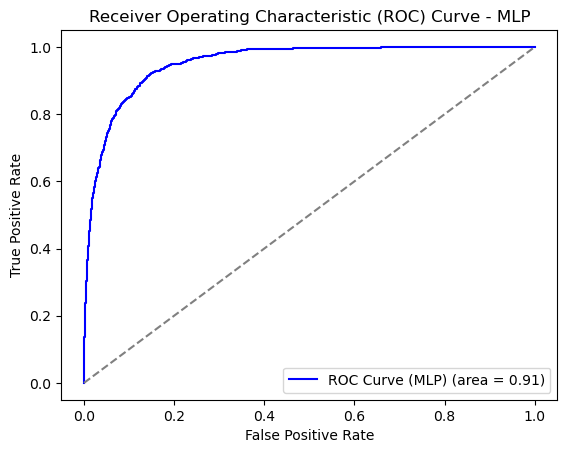

In [11]:
# Plot ROC Curve for MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_true_mlp, np.array(y_scores_mlp)[:, 1], pos_label=1)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, color='blue', label=f'ROC Curve (MLP) (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - MLP')
plt.legend(loc='lower right')
plt.show()